# **Algoritmos de Optimización**

Los algoritmos de Machine Learning a menudo requieren técnicas de optimización para mejorar su rendimiento en términos de velocidad y consumo de memoria sin comprometer la precisión. A continuación, se presentan tres métodos populares:

In [ ]:
# Librerías Importadas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import faiss
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Cargar datos
df = pd.read_csv(r"C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Files\Rentabilidad_filtrado.csv")


In [ ]:

# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "TIPO_PARTICIPACION", "PRECIERRE_FONDO_DIA_T",  "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]


# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **K-NN** `KD-Trees, Ball Trees, FAISS` 

In [18]:
def knn(k, algorithm):
    KNN = KNeighborsRegressor(n_neighbors=k, weights='uniform', algorithm=algorithm, leaf_size=30, n_jobs=-1)
    st = time.time()
    KNN.fit(X_train, y_train)
    et= time.time()
    print(f"Tiempo de entrenamiento: {et-st:.4f} segundos")    
        # Predicciones
    y_train_pred = KNN.predict(X_train)
    y_test_pred = KNN.predict(X_test)
        
        # Calcular R²
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
        
        # Imprimir resultados
    print(f'R² en entrenamiento: {train_r2:.4f}')
    print(f'R² en prueba: {test_r2:.4f}')

Los siguientes resultados muestran el impacto de las diferentes estructuras de datos en la eficiencia del entrenamiento del modelo KNN sin afectar la precisión del modelo. 

### `KD-Trees`

In [19]:
knn(5, 'kd_tree')

Tiempo de entrenamiento: 1.7682 segundos
R² en entrenamiento: 0.7846
R² en prueba: 0.7368


Más lento porque es eficiente solo en dimensiones bajas (~<30). A mayor dimensión, la búsqueda se vuelve casi tan costosa como la fuerza bruta.

### `Ball Trees`

In [24]:
knn(5, 'ball_tree')

Tiempo de entrenamiento: 1.1726 segundos
R² en entrenamiento: 0.7846
R² en prueba: 0.7368


Más rápido que KD-Trees, lo que sugiere que se adapta mejor a la estructura de los datos, especialmente si la distribución de puntos es menos uniforme.

### `FAISS`

In [27]:
# Implementar Faiss KNN
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        start_time = time.time()  # Iniciar cronómetro
        self.index = faiss.IndexFlatL2(X.shape[1])  # Índice Faiss
        self.index.add(X.astype(np.float32))  # Convertir X a float32
        self.y = np.array(y)  # Convertir y a NumPy array
        end_time = time.time()  # Finalizar cronómetro
        print(f"Tiempo de entrenamiento: {end_time - start_time:.4f} segundos")

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.mean(votes, axis=1)  # Promedio de los vecinos (para regresión)
        return predictions

In [28]:
knn_faiss = FaissKNeighbors(k=5)
knn_faiss.fit(X_train, y_train)

# Hacer predicciones en train y test
y_train_pred = knn_faiss.predict(X_train)
y_test_pred = knn_faiss.predict(X_test)

# Evaluación del modelo
print(f'\nR² en entrenamiento: {r2_score(y_train, y_train_pred):.4f}')
print(f'R² en prueba: {r2_score(y_test, y_test_pred):.4f}')

Tiempo de entrenamiento: 0.0229 segundos

R² en entrenamiento: 0.7846
R² en prueba: 0.7368


Drásticamente más rápido, ya que está optimizado para alta dimensionalidad y grandes volúmenes de datos, probablemente usando indexación eficiente y paralelización en CPU/GPU.

FAISS es claramente la mejor opción en términos de tiempo sin pérdida de precisión. 

En comparación con el rendimiento normal del Modelo KNN *(Página Anterior)* notamos que:

**Tiempo de Entrenamiento:** KNN normal (1.47 s) está en un punto intermedio: más rápido que KD-Trees (1.7682 s) pero más lento que Ball Trees (1.1726 s) y muchísimo más lento que FAISS (0.0229 s).

**Precisión:** 
- KNN normal: 0.7340

- KD-Trees, Ball Trees y FAISS: 0.7368

Aunque la diferencia es pequeña, el KNN normal tiene un ligero peor desempeño en prueba. 

## **Ridge** `Solver = saga`

In [20]:
st = time.time()
ridge = Ridge(solver='saga').fit(X_train, y_train)
et = time.time()
print(f"Tiempo de entrenamiento Ridge: {et-st:.4f} segundos")
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Tiempo de entrenamiento Ridge: 2.7812 segundos
Training set score: 0.72
Test set score: 0.70


Solver ‘saga’ (2.7812 s) es mucho más lento que la versión normal (0.18 s).

Esto sugiere que, aunque ‘saga’ está optimizado para grandes volúmenes de datos y características dispersas, en este caso, el tamaño o estructura de los datos podría no estar aprovechando su paralelización.

## **XGBoost** `tree_method='hist', early_stopping_rounds.` 

In [22]:
XGB = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, early_stopping_rounds=20,
    min_child_weight=5,     # Controlar la división de nodos para evitar sobreajuste
    subsample=0.8,          # Tomar muestras de los datos para evitar sobreajuste
    colsample_bytree=0.8,
    reg_lambda=1,           # Regularización L2 (evita sobreajuste)
    tree_method='hist',     # Algoritmo optimizado para conjuntos grandes
    eval_metric="rmse",  random_state=42, n_jobs=-1)
st= time.time()
XGB.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)]) 
et= time.time()
print(f"Tiempo de entrenamiento XGBoost: {et-st:.4f} segundos")

    # Predicciones
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)
    
    # Calcular R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
    # Imprimir resultados
print(f'R² en entrenamiento: {train_r2:.4f}')
print(f'R² en prueba: {test_r2:.4f}')

[0]	validation_0-rmse:41834213630.41076	validation_1-rmse:40867266278.54447
[1]	validation_0-rmse:39248929046.92715	validation_1-rmse:38180506336.29671
[2]	validation_0-rmse:36957946486.98074	validation_1-rmse:35828091844.70522
[3]	validation_0-rmse:35373890382.83579	validation_1-rmse:34119232622.72684
[4]	validation_0-rmse:33623265140.80811	validation_1-rmse:32304800417.45920
[5]	validation_0-rmse:32131709211.81150	validation_1-rmse:30758066980.40246
[6]	validation_0-rmse:30840249840.31030	validation_1-rmse:29450480293.29181
[7]	validation_0-rmse:29811586304.10691	validation_1-rmse:28333506342.41018
[8]	validation_0-rmse:28947083823.27284	validation_1-rmse:27386522304.09840
[9]	validation_0-rmse:28139295285.20079	validation_1-rmse:26601730099.67011
[10]	validation_0-rmse:27593811321.58388	validation_1-rmse:26001378834.91472
[11]	validation_0-rmse:27064695050.35685	validation_1-rmse:25414219040.04436
[12]	validation_0-rmse:26546445132.13224	validation_1-rmse:24927507176.11632
[13]	vali

XGBoost optimizado (4.26 s) es más de 2 veces más rápido que la versión normal (9.37 s). Ligeramente menor R² en entrenamiento (0.7746), pero mejor en prueba (0.7439), lo que sugiere mejor generalización comparado con el normal.

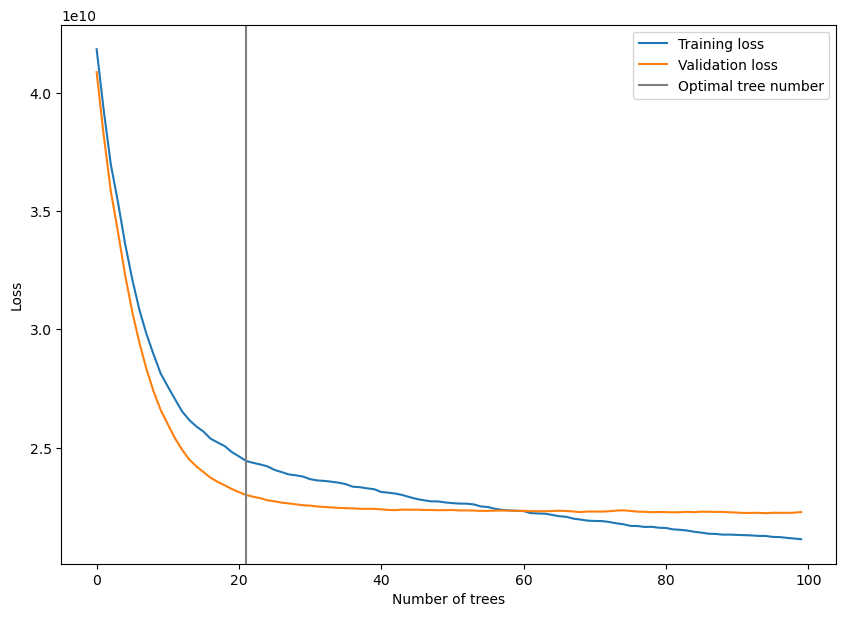

In [23]:
results = XGB.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

Notamos que la pérdida de validación se estabiliza después de este punto, mientras que la de entrenamiento sigue disminuyendo. Esto confirma que el modelo generaliza mejor y es más eficiente que la versión normal.